# Supermarket Sales Analysis

In [353]:
#import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb


In [354]:
#load dataset
df = pd.read_csv("supermarket_sales.csv")
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [355]:
#dimensions of data in format rows,columns
df.shape

(1000, 17)

In [356]:
# Get the size of the DataFrame
df.size

17000

In [357]:
# Count the number of columns with at least one missing value
df.isnull().any().sum()

0

In [358]:
# It gives us null values
df.isnull().sum()

Invoice ID                 0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Total                      0
Date                       0
Time                       0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64

In [359]:
#The method in pandas is used to identify duplicate rows in a DataFrame
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Length: 1000, dtype: bool

In [360]:
# Generate descriptive statistics
df.describe()

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1.000000e+03,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905e+00,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,6.131498e-14,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905e+00,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905e+00,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905e+00,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905e+00,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905e+00,49.650000,10.00000


In [361]:
# Calculate the mean of all numeric columns
print(df.mean(numeric_only=True))

Unit price                  55.672130
Quantity                     5.510000
Tax 5%                      15.379369
Total                      322.966749
cogs                       307.587380
gross margin percentage      4.761905
gross income                15.379369
Rating                       6.972700
dtype: float64


In [362]:
# Remove unnecessary columns that don't contribute to sales prediction
df.drop(['Invoice ID', 'Date', 'Time', 'gross margin percentage'], axis=1, inplace=True)

In [363]:
# Encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df, columns=['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Payment'], drop_first=False)

In [364]:
df.nunique()

Branch             3
City               3
Customer type      2
Gender             2
Product line       6
Unit price       943
Quantity          10
Tax 5%           990
Total            990
Payment            3
cogs             990
gross income     990
Rating            61
dtype: int64

In [365]:
df['Payment'].unique()

array(['Ewallet', 'Cash', 'Credit card'], dtype=object)

In [366]:
df_encoded

,Unit price,Quantity,Tax 5%,Total,cogs,gross income,Rating,Branch_A,Branch_B,Branch_C,...,Gender_Male,Product line_Electronic accessories,Product line_Fashion accessories,Product line_Food and beverages,Product line_Health and beauty,Product line_Home and lifestyle,Product line_Sports and travel,Payment_Cash,Payment_Credit card,Payment_Ewallet
0,74.69,7,26.1415,548.9715,522.83,26.1415,9.1,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,15.28,5,3.8200,80.2200,76.40,3.8200,9.6,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2,46.33,7,16.2155,340.5255,324.31,16.2155,7.4,1,0,0,...,1,0,0,0,0,1,0,0,1,0
3,58.22,8,23.2880,489.0480,465.76,23.2880,8.4,1,0,0,...,1,0,0,0,1,0,0,0,0,1
4,86.31,7,30.2085,634.3785,604.17,30.2085,5.3,1,0,0,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,40.35,1,2.0175,42.3675,40.35,2.0175,6.2,0,0,1,...,1,0,0,0,1,0,0,0,0,1
996,97.38,10,48.6900,1022.4900,973.80,48.6900,4.4,0,1,0,...,0,0,0,0,0,1,0,0,0,1
997,31.84,1,1.5920,33.4320,31.84,1.5920,7.7,1,0,0,...,1,0,0,1,0,0,0,1,0,0
998,65.82,1,3.2910,69.1110,65.82,3.2910,4.1,1,0,0,...,1,0,0,0,0,1,0,1,0,0


In [367]:
df_encoded.columns

Index(['Unit price', 'Quantity', 'Tax 5%', 'Total', 'cogs', 'gross income',
       'Rating', 'Branch_A', 'Branch_B', 'Branch_C', 'City_Mandalay',
       'City_Naypyitaw', 'City_Yangon', 'Customer type_Member',
       'Customer type_Normal', 'Gender_Female', 'Gender_Male',
       'Product line_Electronic accessories',
       'Product line_Fashion accessories', 'Product line_Food and beverages',
       'Product line_Health and beauty', 'Product line_Home and lifestyle',
       'Product line_Sports and travel', 'Payment_Cash', 'Payment_Credit card',
       'Payment_Ewallet'],
      dtype='object')

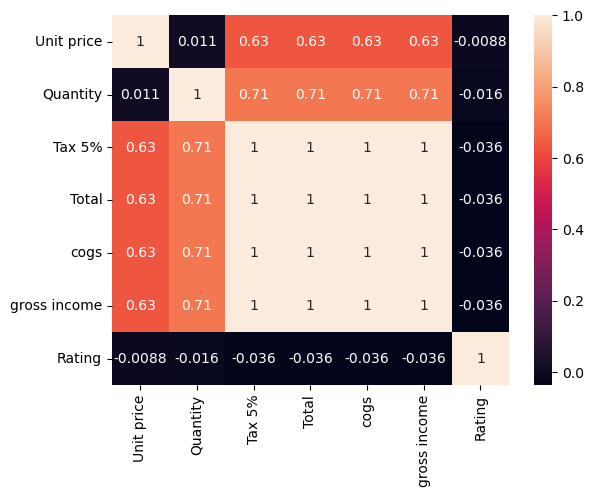

Unit price       55.672130
Quantity          5.510000
Tax 5%           15.379369
Total           322.966749
cogs            307.587380
gross income     15.379369
Rating            6.972700
dtype: float64


/var/folders/n1/bp929_sx74q65yzn_wfsq_pc0000gn/T/ipykernel_952/3987361071.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  means = df.mean()


In [368]:
# Calculate the correlation matrix
corrMatrix = df.corr()

# Display the heatmap
sns.heatmap(corrMatrix, annot=True)
plt.show()

# If you want to calculate means, you can do something like this
means = df.mean()
print(means)

In [369]:
#the number of unique values for each feature (column) in your DataFrame
for column_name in df.columns:
    unique_values = len(df[column_name].unique())
    print(f"Feature '{column_name}' has '{unique_values}' unique values")

Feature 'Branch' has '3' unique values
Feature 'City' has '3' unique values
Feature 'Customer type' has '2' unique values
Feature 'Gender' has '2' unique values
Feature 'Product line' has '6' unique values
Feature 'Unit price' has '943' unique values
Feature 'Quantity' has '10' unique values
Feature 'Tax 5%' has '990' unique values
Feature 'Total' has '990' unique values
Feature 'Payment' has '3' unique values
Feature 'cogs' has '990' unique values
Feature 'gross income' has '990' unique values
Feature 'Rating' has '61' unique values


In [370]:
# Get unique city names
df["City"].unique()

array(['Yangon', 'Naypyitaw', 'Mandalay'], dtype=object)

In [371]:
# Get the count of occurrences for each city
df['City'].value_counts()

Yangon       340
Mandalay     332
Naypyitaw    328
Name: City, dtype: int64

In [372]:
# Group by 'City' and sum the 'Total' values for each group
df.groupby('City')
df_sales=df.groupby("City").sum()
# Sort the DataFrame by the 'Total' column in descending order
df_sales['Total'].sort_values(ascending=False)

City
Naypyitaw    110568.7065
Yangon       106200.3705
Mandalay     106197.6720
Name: Total, dtype: float64

In [373]:
# Calculate the mean of each column in the df_sales DataFrame
df_sales.mean()

Unit price       18557.376667
Quantity          1836.666667
Tax 5%            5126.456333
Total           107655.583000
cogs            102529.126667
gross income      5126.456333
Rating            2324.233333
dtype: float64

In [374]:
# Group by 'City' and sum the 'Quantity' values for each group
df_quantity=df.groupby("City").sum()

# Sort the DataFrame by the 'Quantity' column in descending order
df_quantity['Quantity'].sort_values(ascending=False)

City
Yangon       1859
Naypyitaw    1831
Mandalay     1820
Name: Quantity, dtype: int64

In [375]:
df_rating=df.groupby("City").sum()
df_rating['Rating'].sort_values(ascending=False)

City
Yangon       2389.2
Naypyitaw    2319.9
Mandalay     2263.6
Name: Rating, dtype: float64

In [376]:
df["Customer type"].unique()

array(['Member', 'Normal'], dtype=object)

In [377]:
df.groupby('Customer type').size()

Customer type
Member    501
Normal    499
dtype: int64

In [378]:
df.groupby('Gender').size()

Gender
Female    501
Male      499
dtype: int64

In [379]:
df["Payment"].unique()

array(['Ewallet', 'Cash', 'Credit card'], dtype=object)

In [380]:
df.groupby('Payment').size()

Payment
Cash           344
Credit card    311
Ewallet        345
dtype: int64

In [381]:
 df["Product line"].unique()

array(['Health and beauty', 'Electronic accessories',
       'Home and lifestyle', 'Sports and travel', 'Food and beverages',
       'Fashion accessories'], dtype=object)

In [382]:
product=df.groupby("Product line").sum()
product["Total"].sort_values(ascending=False)

Product line
Food and beverages        56144.8440
Sports and travel         55122.8265
Electronic accessories    54337.5315
Fashion accessories       54305.8950
Home and lifestyle        53861.9130
Health and beauty         49193.7390
Name: Total, dtype: float64

In [383]:
product["Quantity"].sort_values(ascending=False)

Product line
Electronic accessories    971
Food and beverages        952
Sports and travel         920
Home and lifestyle        911
Fashion accessories       902
Health and beauty         854
Name: Quantity, dtype: int64

In [384]:
product["gross income"].sort_values(ascending=False)

Product line
Food and beverages        2673.5640
Sports and travel         2624.8965
Electronic accessories    2587.5015
Fashion accessories       2585.9950
Home and lifestyle        2564.8530
Health and beauty         2342.5590
Name: gross income, dtype: float64

In [385]:
df["Rating"].unique()

array([ 9.1,  9.6,  7.4,  8.4,  5.3,  4.1,  5.8,  8. ,  7.2,  5.9,  4.5,
        6.8,  7.1,  8.2,  5.7,  4.6,  6.9,  8.6,  4.4,  4.8,  5.1,  9.9,
        6. ,  8.5,  6.7,  7.7,  7.5,  7. ,  4.7,  7.6,  7.9,  6.3,  5.6,
        9.5,  8.1,  6.5,  6.1,  6.6,  5.4,  9.3, 10. ,  6.4,  4.3,  4. ,
        8.7,  9.4,  5.5,  8.3,  7.3,  4.9,  4.2,  9.2,  7.8,  5.2,  9. ,
        8.8,  6.2,  9.8,  9.7,  5. ,  8.9])

In [386]:
df['Rating'].value_counts()

6.0     26
6.6     24
4.2     22
9.5     22
6.5     21
        ..
4.0     11
5.3     11
8.3     11
4.6      8
10.0     5
Name: Rating, Length: 61, dtype: int64

In [387]:
# Calculate the median rating for each product line and sort in descending order
df['Rating'].groupby(df['Product line']).median().sort_values(ascending=False)

Product line
Food and beverages        7.30
Health and beauty         7.20
Home and lifestyle        7.00
Fashion accessories       6.95
Electronic accessories    6.70
Sports and travel         6.70
Name: Rating, dtype: float64

In [388]:
# Get specific groups
gb=df.groupby('City')
yangon_df=gb.get_group("Yangon")
Naypyitaw_df=gb.get_group("Naypyitaw")
Mandalay_df=gb.get_group("Mandalay")

In [389]:
yangon_df.groupby('Customer type').size()

Customer type
Member    167
Normal    173
dtype: int64

In [390]:
yangon_df.groupby('Gender').size()

Gender
Female    161
Male      179
dtype: int64

In [391]:
yangon_df.groupby(['Customer type', 'Gender']).size()

Customer type  Gender
Member         Female    80
               Male      87
Normal         Female    81
               Male      92
dtype: int64

In [392]:
yangon_df.groupby('Payment').size().sort_values(ascending=False)

Payment
Ewallet        126
Cash           110
Credit card    104
dtype: int64

In [393]:
yangon_df['Total'].groupby(yangon_df['Product line']).sum().sort_values(ascending=False)

Product line
Home and lifestyle        22417.1955
Sports and travel         19372.6995
Electronic accessories    18317.1135
Food and beverages        17163.1005
Fashion accessories       16332.5085
Health and beauty         12597.7530
Name: Total, dtype: float64

In [394]:
yangon_df['Quantity'].groupby(yangon_df['Product line']).sum().sort_values(ascending=False)

Product line
Home and lifestyle        371
Sports and travel         333
Electronic accessories    322
Food and beverages        313
Fashion accessories       263
Health and beauty         257
Name: Quantity, dtype: int64

In [395]:
yangon_df.groupby(['Gender', 'Customer type', 'Product line']).size().sort_values(ascending=False)

Gender  Customer type  Product line          
Male    Member         Electronic accessories    19
                       Food and beverages        19
        Normal         Sports and travel         19
        Member         Home and lifestyle        18
Female  Member         Sports and travel         18
        Normal         Electronic accessories    16
                       Fashion accessories       16
                       Home and lifestyle        16
Male    Normal         Health and beauty         16
                       Food and beverages        16
Female  Member         Home and lifestyle        16
Male    Normal         Home and lifestyle        15
Female  Normal         Food and beverages        13
Male    Normal         Fashion accessories       13
                       Electronic accessories    13
Female  Member         Health and beauty         12
                       Electronic accessories    12
                       Fashion accessories       12
Male    Member    

In [396]:
yangon_df['Rating'].value_counts()

4.2     11
6.6     11
7.4      9
9.1      8
6.0      8
        ..
8.1      3
5.3      2
6.3      2
4.0      2
10.0     1
Name: Rating, Length: 61, dtype: int64

In [397]:
yangon_df['Rating'].groupby(yangon_df['Product line']).median().sort_values(ascending=False)

Product line
Food and beverages        7.45
Sports and travel         7.40
Fashion accessories       7.20
Home and lifestyle        7.00
Electronic accessories    6.80
Health and beauty         6.80
Name: Rating, dtype: float64

### Model Building

##### Split Data into Features and Target


In [398]:
# Split the dataset into features (X) and the target variable (y)
X = df_encoded.drop('Total', axis=1)
y = df_encoded['Total']

In [399]:
X.nunique()

Unit price                             943
Quantity                                10
Tax 5%                                 990
cogs                                   990
gross income                           990
Rating                                  61
Branch_A                                 2
Branch_B                                 2
Branch_C                                 2
City_Mandalay                            2
City_Naypyitaw                           2
City_Yangon                              2
Customer type_Member                     2
Customer type_Normal                     2
Gender_Female                            2
Gender_Male                              2
Product line_Electronic accessories      2
Product line_Fashion accessories         2
Product line_Food and beverages          2
Product line_Health and beauty           2
Product line_Home and lifestyle          2
Product line_Sports and travel           2
Payment_Cash                             2
Payment_Cre

In [400]:
y

0       548.9715
1        80.2200
2       340.5255
3       489.0480
4       634.3785
         ...    
995      42.3675
996    1022.4900
997      33.4320
998      69.1110
999     649.2990
Name: Total, Length: 1000, dtype: float64

### Standardize Numerical Features

In [401]:
# Standardize numerical features to have mean=0 and standard deviation=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [402]:
# Split the data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Linear Regression

In [403]:
# Import necessary libraries
from sklearn import linear_model
from sklearn import metrics

In [404]:
li_model = linear_model.LinearRegression()
li_model.fit(X_train, y_train)
y_pred =li_model.predict(X_test)

In [405]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('r2_score:',r2_score(y_test,y_pred))

Mean Absolute Error: 3.1084468332664984e-13
Mean Squared Error: 1.4154531222380615e-25
Root Mean Squared Error: 3.762250818643092e-13
r2_score: 1.0


In [406]:
li_result=pd.DataFrame({'Actual Value': y_test, 'Predicted Value': y_pred})
li_result.head(10)

,Actual Value,Predicted Value
521,523.9710,523.9710
737,616.9800,616.9800
740,408.7335,408.7335
660,135.3555,135.3555
411,45.9270,45.9270
678,618.9750,618.9750
626,127.8270,127.8270
513,731.6925,731.6925
859,450.1035,450.1035
136,138.1275,138.1275


<AxesSubplot:>

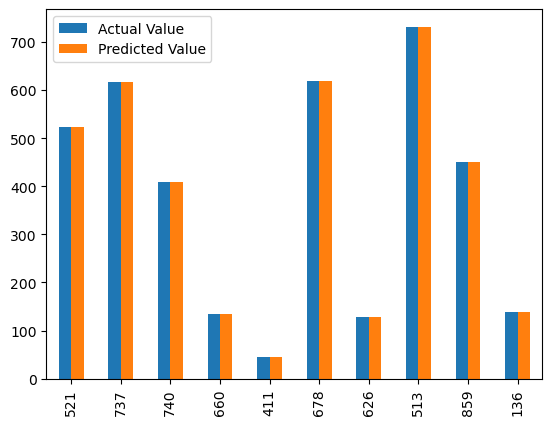

In [407]:
li_graph = li_result.head(10)
li_graph.plot(kind='bar')

### Random Forest

In [408]:
 # create regressor object
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 0)
  
# fit the regressor with x and y data
rf_model.fit(X_train, y_train) 
y_pred = rf_model.predict(X_test)

In [409]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('r2_score:',r2_score(y_test,y_pred))

Mean Absolute Error: 0.741085274999991
Mean Squared Error: 1.4996001501101055
Root Mean Squared Error: 1.2245816224776958
r2_score: 0.9999769501528768


In [410]:
rf_result=pd.DataFrame({'Actual Value': y_test, 'Predicted Value': y_pred})
rf_result.head(10)

,Actual Value,Predicted Value
521,523.9710,522.490605
737,616.9800,621.061875
740,408.7335,408.369780
660,135.3555,136.053960
411,45.9270,44.790585
678,618.9750,621.976425
626,127.8270,127.097040
513,731.6925,732.934755
859,450.1035,451.455165
136,138.1275,137.934720


### Support Vector Machine (SVM)

In [411]:
model = SVR(kernel='linear')

model.fit(X_train, y_train)

predictions = model.predict(X_test)

In [412]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('r2_score:',r2_score(y_test,y_pred))

Mean Absolute Error: 0.741085274999991
Mean Squared Error: 1.4996001501101055
Root Mean Squared Error: 1.2245816224776958
r2_score: 0.9999769501528768


## K N N

In [413]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=50)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [414]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('r2 score:',r2_score(y_test,y_pred))

Mean Absolute Error: 85.08105900000001
Mean Squared Error: 10585.522420250716
Root Mean Squared Error: 102.8859680435127
r2 score: 0.8372935122151359


### XGBOOST

In [415]:
from xgboost import XGBClassifier

xgb = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)



ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449
 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521
 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539
 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557
 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575
 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719
 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737
 738 739 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755
 756 757 758 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773
 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791
 792], got [  12.6945   13.167    13.419    14.679    16.107    16.2015   16.275
   17.094    18.6375   19.2465   20.685    22.386    22.659    23.499
   23.751    24.108    25.263    26.25     26.5545   26.733    26.796
   28.4235   30.219    30.408    31.227    31.752    31.9305   32.1405
   32.151    32.529    33.3585   33.432    33.495    35.196    35.3115
   36.5505   37.611    37.6845   40.341    40.9605   41.076    41.454
   41.7375   43.869    44.352    44.9925   45.108    47.859    48.51
   48.7305   49.308    49.4235   49.77     49.812    51.0405   51.1455
   53.151    53.34     53.928    54.0435   54.9675   54.999    55.041
   55.2825   55.881    56.1225   56.406    56.952    57.078    57.1725
   57.876    58.2225   59.325    62.0025   63.315    63.9135   63.9975
   65.7405   66.402    66.8745   68.985    69.405    69.72     69.993
   71.1585   71.526    71.568    72.009    72.3975   72.429    72.87
   72.933    74.088    74.4555   74.76     75.054    75.474    75.7785
   76.146    76.356    76.5765   76.923    77.175    77.658    77.6685
   77.7735   77.805    78.0045   78.435    78.603    78.7185   79.149
   79.611    79.674    80.22     80.367    80.661    80.955    81.396
   82.719    82.887    83.412    83.727    84.63     84.7455   85.113
   85.302    85.512    85.5855   85.743    86.625    87.234    88.368
   88.704    90.5835   90.825    90.867    91.056    91.4025   91.56
   91.77     91.8225   92.295    92.442    92.5575   92.7255   92.8725
   93.114    93.2925   93.744    94.1745   94.2375   95.865    95.9175
   96.138    96.579    96.642    97.419    97.818    97.881    98.028
   98.049    99.33     99.54     99.75     99.9075  100.128   100.485
  100.9155  101.808   102.018   102.396   102.837   103.0365  103.11
  103.131   103.635   103.782   103.824   104.832   106.596   106.995
  107.142   107.31    110.0925  110.124   112.224   113.568   115.08
  115.185   116.1405  116.907   117.831   118.062   118.902   119.259
  120.162   120.645   121.569   121.59    121.863   122.472   122.5245
  125.055   125.517   125.664   125.7165  125.979   128.4255  130.032
  130.0425  131.208   132.027   132.5625  132.762   133.35    133.434
  133.917   135.45    135.576   136.143   137.004   137.865   138.978
  139.923   140.385   140.6475  141.75    142.947   143.22    143.9865
  144.081   145.068   145.404   145.593   145.74    145.971   146.328
  146.6325  146.9475  148.974   149.3625  150.0975  150.423   150.78
  151.284   151.4835  151.515   152.019   152.712   152.775   153.048
  154.1295  154.392   155.19    155.652   156.03    160.209   160.44
  160.86    161.553   161.7     162.75    163.002   163.233   163.611
  164.43    164.871   165.123   165.4485  165.648   165.9     166.1625
  166.635   167.034   167.895   168.21    169.3125  170.877   171.7275
  172.2105  172.494   172.746   173.208   174.615   175.035   175.0455
  175.14    175.917   176.4     176.925   177.408   178.164   180.4005
  180.6     180.621   181.0725  181.818   181.881   182.427   182.91
  182.952   183.036   183.12    183.645   184.086   184.107   185.367
  186.228   187.32    187.866   189.0945  190.4805  190.596   191.247
  193.4625  194.124   194.985   195.174   195.258   195.678   195.72
  195.951   196.14    197.925   198.996   200.214   202.335   202.818
  203.112   203.175   203.553   203.931   204.246   204.6975  205.317
  206.43    206.7975  206.808   207.48    207.585   207.858   208.089
  208.425   208.677   208.6875  209.118   209.559   209.622   210.966
  212.688   212.73    213.528   214.137   214.935   214.998   216.6885
  217.182   217.2555  217.6335  218.0115  222.012   223.0725  223.587
  224.4375  225.015   225.2775  225.792   226.065   229.11    231.2415
  232.638   233.226   233.52    234.0975  235.2105  235.683   235.746
  236.88    239.4     239.589   240.975   241.458   242.676   244.23
  246.4875  246.6765  247.59    248.409   250.278   250.7085  251.7165
  252.756   253.26    253.512   253.68    254.016   255.15    255.1815
  256.41    256.7775  257.145   258.678   262.458   262.794   263.13
  263.97    264.7575  265.104   266.028   266.6475  267.3405  269.535
  270.018   270.2595  271.278   271.2885  271.95    272.58    272.664
  273.0525  273.42    273.798   276.948   277.137   277.6725  277.788
  279.1845  279.384   280.035   282.492   282.576   284.193   284.592
  284.9175  285.705   287.91    288.015   288.204   288.582   289.926
  290.43    291.207   291.438   293.202   293.643   294.651   295.6905
  296.94    297.108   297.801   298.116   299.3655  299.565   299.8485
  300.216   304.542   304.92    304.983   306.81    308.91    309.3615
  310.044   310.716   311.1885  312.8895  313.572   314.055   314.538
  314.685   316.47    317.226   317.835   318.108   319.788   321.111
  321.7725  323.148   324.2925  325.374   326.256   326.424   328.755
  329.196   333.207   333.9525  334.341   335.013   335.895   336.5565
  337.512   338.2155  338.31    339.36    340.5255  341.0925  343.413
  344.4     345.0195  345.786   348.705   350.07    351.099   351.603
  352.2225  352.674   353.094   353.1675  354.0075  356.328   356.5485
  357.588   359.205   360.885   360.927   362.712   362.817   362.943
  365.085   365.904   367.038   367.5525  369.495   369.684   373.17
  374.409   375.3645  377.58    383.523   384.468   388.29    390.7995
  390.9465  392.6475  394.275   394.3275  394.632   397.845   397.992
  398.475   398.958   399.756   401.268   401.688   402.2655  403.872
  404.544   404.649   406.875   407.316   408.408   408.492   410.508
  411.3795  415.233   417.564   418.95    419.832   420.2625  423.15
  423.738   427.812   429.1665  431.256   432.9885  433.692   435.12
  435.456   437.325   439.215   439.8975  440.937   441.588   441.693
  442.323   446.439   446.964   451.0275  451.3635  451.71    452.865
  453.495   455.1225  457.38    457.443   458.6925  461.328   462.21
  462.672   463.89    465.444   469.413   469.77    470.673   470.988
  471.03    472.311   474.348   477.1305  477.54    478.233   479.9025
  480.0285  484.5225  484.89    484.974   485.037   486.444   488.985
  489.048   491.085   493.794   497.07    499.7265  503.7375  506.6355
  507.444   507.675   507.906   509.4075  510.9615  510.972   512.19
  513.2295  514.605   514.773   517.965   520.4115  520.8     521.01
  523.845   527.5095  527.751   529.515   530.67    532.728   535.374
  535.7205  536.592   536.844   536.991   539.343   543.753   545.055
  545.37    548.163   548.184   548.73    548.7615  548.9715  550.368
  550.935   551.124   554.148   554.295   557.718   561.078   565.215
  568.512   571.41    572.775   575.316   575.736   575.9775  580.419
  586.635   586.971   588.357   590.436   596.82    597.6285  603.624
  603.876   608.076   608.202   609.588   610.491   611.079   620.739
  621.243   624.897   625.905   627.6165  628.173   628.929   629.16
  629.496   629.8425  631.1445  633.99    634.3785  637.728   640.038
  649.299   652.26    652.89    655.5465  657.531   663.2955  666.939
  671.79    673.995   680.064   680.148   680.61    681.975   684.915
  688.6215  688.716   690.018   695.2365  702.219   703.752   705.6315
  708.225   708.3195  714.3255  718.7565  720.3     721.98    728.112
  731.43    732.27    733.6035  734.076   734.706   736.4385  737.7615
  742.812   743.82    745.395   749.49    749.7     752.64    756.168
  759.675   760.4415  763.4655  767.025   769.104   771.435   772.38
  781.62    782.208   783.3     786.618   793.716   794.6505  801.864
  804.3     807.66    810.6     814.38    817.236   827.085   829.08
  829.71    830.3715  832.944   833.595   833.9625  835.2855  843.0345
  852.705   853.146   860.475   860.685   864.57    867.09    867.615
  874.125   881.307   887.922   888.405   888.615   914.55    921.186
  931.035   935.2665  936.6     937.818   942.9     944.622   950.25
 1002.12   1003.59   1020.705  1022.385  1022.49   1023.75   1034.46
 1039.29   1042.65  ]

In [416]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('r2 score:',r2_score(y_test,y_pred))

Mean Absolute Error: 85.08105900000001
Mean Squared Error: 10585.522420250716
Root Mean Squared Error: 102.8859680435127
r2 score: 0.8372935122151359
